In [1]:
!pip3 install -q networkx numpy matplotlib openai asyncio

In [2]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import openai
from dataclasses import dataclass

# set the OpenAI API key
with open("config.json", "r") as f:
    cfg = json.load(f)

client = openai.OpenAI(api_key=cfg["chatgpt_api_key"])

In [3]:
# create small-world graph with 150 nodes
N = 150
# n = num of nodes
# k = each node is connected to k nearest neighbors in ring topology
# p = probability of rewiring each edge
G = nx.watts_strogatz_graph(n=N, k=4, p=0.1, seed=42)

# attach node attributes
for node in G.nodes():
    G.nodes[node].update({
        'trust_official': float(np.random.rand()), # [0, 1]
        'susceptibility': float(np.random.rand()), # [0, 1]
        'belief_threshold': 0.5, # fixed threshold
        'share_threshold': 0.5,
        'memory': set() # encountered claims
    })

In [4]:
# define messgae structure and decision functions
@dataclass
class Message:
    text: str
    origin: str # node ID or "official"
    truth: bool # true/false claim

def compute_belief(agent, msg: Message) -> float:
    # Belief: trust if official, else susceptibility
    if msg.origin == 'official':
        base = agent['trust_official']
    else:
        base = agent['susceptibility']
    
    return base * (0.8 if msg.text in agent['memory'] else 1.0) # trust if already encountered

def compute_share(agent, belief_score: float) -> bool:
    # share when belief_score goes over threshold
    return belief_score >= agent['share_threshold']

In [5]:
# LLM-based post generation
async def generate_post(agent_id:int, message_text:str) -> str:
    prompt = (
        f"You are user #{agent_id} who BELIEVES the following claim: \"{message_text}\".\n"
        "Write a social media post to share this information in you rown style."
    )

    resp = await client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user",
                   "content": prompt}],
                   temperature=0.7
    )

    return resp.choices[0].message.content.strip()

In [8]:
import random

# seed a false rumor
seed = Message(text="Breaking News: Starbucks is sponsoring the Republican National Convention in Milwaukee.", 
               origin="botnet", 
               truth=False)
inboxes = {n: [] for n in G.nodes()}
for s in random.sample(list(G.nodes()), k=3):
    inboxes[s].append(seed)

believers_over_time = [] # list of believers

T = 10 # time steps
for t in range(T):

    new_inboxes = {n:[] for n in G.nodes()}
    for node in G.nodes():
        agent = G.nodes[node]

        for msg in inboxes[node]:
            b = compute_belief(agent, msg) # belief score
            agent['memory'].add(msg.text) # add to memory

            if compute_share(agent, b):
                for nbr in G.neighbors(node):
                    new_inboxes[nbr].append(msg)
    
    # inject an "official" bebunk at step 6
    if t == 6:
        correction = Message(text="Fact-check:  False. Starbucks is providing coffee and other beverages to first responders at five RNC venues through a partnership with the Milwaukee 2024 Host Committee, according to a spokesperson for the company. It is not providing a cash sponsorship of any kind.", 
                             origin="official", 
                             truth=True)
        for n in G.nodes():
            if G.nodes[n]['trust_official'] > 0.7:
                new_inboxes[n].append(correction)
        
    inboxes = new_inboxes

    # count cumulative believers
    cumul_believers = sum(1 for n in G.nodes() if seed.text in G.nodes[n]['memory'])
    believers_over_time.append(cumul_believers)
    print(
        f"Step {t:2d}: {cumul_believers} agents out of {N}, "
        f"or {cumul_believers/N:.2%} are believers."
    )

Step  0: 29 agents out of 150, or 19.33% are believers.
Step  1: 37 agents out of 150, or 24.67% are believers.
Step  2: 42 agents out of 150, or 28.00% are believers.
Step  3: 49 agents out of 150, or 32.67% are believers.
Step  4: 54 agents out of 150, or 36.00% are believers.
Step  5: 54 agents out of 150, or 36.00% are believers.
Step  6: 54 agents out of 150, or 36.00% are believers.
Step  7: 54 agents out of 150, or 36.00% are believers.
Step  8: 54 agents out of 150, or 36.00% are believers.
Step  9: 54 agents out of 150, or 36.00% are believers.


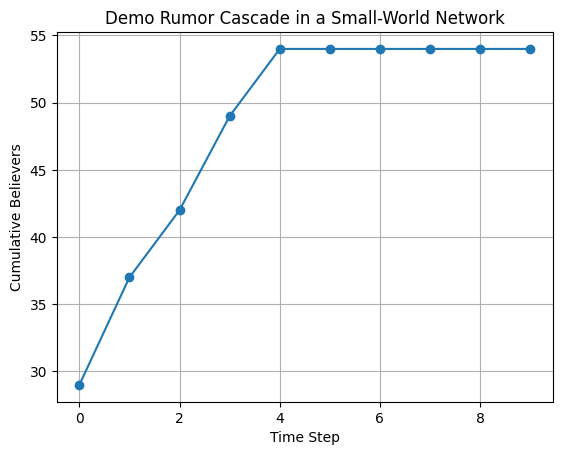

In [9]:
# plot the spread curve
plt.plot(range(T), believers_over_time, marker='o')
plt.title("Demo Rumor Cascade in a Small-World Network")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Believers")
plt.grid(True)
plt.show()